In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [24]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base.classes.keys()

['measurement', 'station']

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2017-08-23


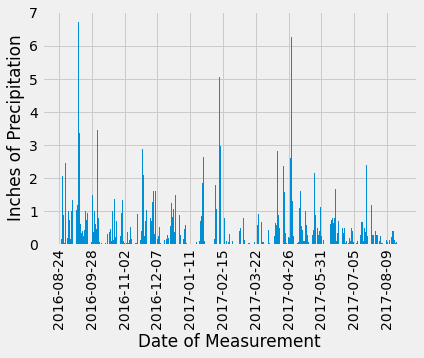

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#get last date
precip = session.query(Measurement).order_by(Measurement.date.desc()).first()

last_date = precip.date
print(last_date)
# Calculate the date 1 year ago from the last data point in the database
date_obj = dt.datetime.strptime(last_date, '%Y-%m-%d')
one_year_obj = date_obj.replace(year=date_obj.year-1)

# Perform a query to retrieve the data and precipitation scores
precip_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_obj).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_scores)
precip_df.set_index('date', inplace=True)

# Sort the dataframe by date
precip_df.sort_index(inplace=True)

# drop NaN values
clean_precip = precip_df.dropna()
clean_precip.head()
# Use Pandas Plotting with Matplotlib to plot the data

plt.bar(clean_precip.index, clean_precip["prcp"])
plt.xlabel("Date of Measurement")
plt.ylabel("Inches of Precipitation")
plt.xticks(np.arange(0, 365, step=35))
plt.xticks(rotation=90)
plt.show()

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#For only the last year
print(clean_precip[['prcp']].describe())

              prcp
count  2015.000000
mean      0.176462
std       0.460288
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


In [11]:
# Design a query to show how many stations are available in this dataset?

count_station = session.query(Measurement.station).distinct(Measurement.station).count()
count_station


9

In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# Join the tables first
stations_data = session.query(Measurement.station).\
    join(Station, Station.station == Measurement.station).all()

stations_df = pd.DataFrame(stations_data)
grouped_stations_df = stations_df.groupby('station')
stations_count = grouped_stations_df['station'].count()

stations_df = pd.DataFrame(stations_count)
stations_df.rename(columns={"station": "count"}, inplace=True)
stations_df.sort_values(by='count', ascending=False, inplace=True)
stations_df

,count
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#Which station is most active?
most_active=stations_df.head(1)
station_id = most_active.index.values

stations_temp_data = session.query(Measurement.station, Measurement.tobs).\
     join(Station, Station.station == Measurement.station).\
     filter(Measurement.date >= one_year_obj).\
     filter(Measurement.station == station_id[0]).all()  # station_id[0] is the most active found above
stations_temp_df = pd.DataFrame(stations_temp_data)
stations_temp_df.head()
min_temp = stations_temp_df['tobs'].min()
max_temp = stations_temp_df['tobs'].max()
average_temp = stations_temp_df['tobs'].mean()
print(f'Min Temp: {min_temp}')
print(f'Max Temp: {max_temp}')
print(f'Average Temp: {average_temp}')

Min Temp: 59.0
Max Temp: 83.0
Average Temp: 73.0968660968661


(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 52., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

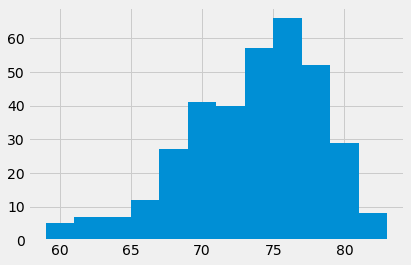

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stations_temp_data_12 = session.query(Measurement.tobs).\
     join(Station, Station.station == Measurement.station).\
     filter(Measurement.date >= one_year_obj).\
     filter(Measurement.station == station_id[0]).all()

# need a simpler list
temps = []
for temp in stations_temp_data_12:
    temps.append(temp.tobs)

# Histogram with 12 bins
bins = 12
fig,ax = plt.subplots(1,1)
ax.hist(temps, bins)

In [15]:
#close the session -- move this to bonus if continuing on
session.close()

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
